# Exploration et filtre des données

L'objectif de ce notebook est de trouver les décisions qui correspondent à ce que l'on cherche. 

A savoir : des décisions qui concernent un recours par une entreprise ou un particulier contre une majoration de ses impôts.

Plusieurs types de majorations peuvent exister :

- 40% : manquement délibéré (mauvaise foi du contribuable)
- 80% : abus de droit (tu fais un montage pour payer moins d’impôt)
- 100% : opposition à contrôle fiscal


## 0. Installation et import des librairies

In [7]:
!pip install -q tqdm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import xml
import xml.etree.ElementTree

## 1. Lecture d'un fichier test pour comprendre son agencement

Par exemple, le fichier n° 19LY01259, qui concerne une décharge du contribuable.

In [7]:
# lecture du csv qui contient les données analysées dans le notebook 1
df = pd.read_csv("../data/intermediate_data.csv")

C:\Users\basil\AppData\Local\Temp\ipykernel_7984\3663729244.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/intermediate_data.csv")


In [3]:
# on récupère le chemin du fichier désiré
path = df[df.id == "21MA02603"]["path"].values[0]

# on ouvre le fichier avec Visual Studio Code
os.system(f"code {path}")

0

## 2. Filtre des décisions

### 2.1 Filtre par mots-clés

On cherche des mots clés pour discriminer les différentes majorations en étant les plus prudents possibles (on ne veut garder que les bones décisions, au risque d'en rater quelques unes).

In [ ]:
# mot clé pour les majorations de 40%
mots_cles_40 = ["manquement délibéré"]

# mot clé pour les majorations de 80%
mots_cles_80 = ["abus de droit"]

# mot clé pour les majorations de 100%
mots_cles_100 = ["opposition à contrôle fiscal"]


# fonction pour trouver les mots clés dans un texte
def find_mots_cles(text, mots_cles):
    # pour tous les mots clés cherchés
    for mot in mots_cles:
        # si on trouve un mot clé
        if re.search(mot, text):
            # on retourne True
            return True
    # si on ne trouve aucun mot clé, on retourne False
    return False


# fonction pour trouver à quelle majoration correspond un texte
def discriminate_majoration(text):
    # si c'est une majoration de 40%
    if find_mots_cles(text, mots_cles_40):
        return "40%"
    # si c'est une majoration de 80%
    elif find_mots_cles(text, mots_cles_80):
        return "80%"
    # si c'est une majoration de 100%
    elif find_mots_cles(text, mots_cles_100):
        return "100%"
    # sinon, on ne sait pas
    else:
        return "other"


# fonction pour lire un fichier et discriminer la majoration
def read_and_discriminate_majoration(path):
    # on ouvre le fichier
    with open(path, "r") as file:
        # on lit le texte
        try :
            text = file.read()
        except:
            return "error"
    # on discrimine la majoration avec la fonction précédente
    return    discriminate_majoration(text)
   
# barre de progression pour voir où on en est
tqdm.pandas()

# application de la fonction à tous les fichiers    
df["majoration"] = df.path.progress_apply(read_and_discriminate_majoration)

# on ne garde que les majorations qui ont été trouvées
df = df[df.majoration != "other"]

# sauvegarde du dataframe pour garder les données
df.to_csv("../data/intermediate_data.csv", index=False)

### 2.2 Filtre par type de recours

Toutes les décisions que nous avons filtrées grâce à des mots-clés peuvent appartenir à différents types de recours.

Nous allons voir si on peut discriminer les bonnes décisions grâce à ces types de recours.

En effet il est possible d'avoir une décision qui contient le mot "abus de pouvoir" mais n'a rien à voir [(ex)](../data/raw/DCA/2022/03/ORCA_22PA00265_20220331.xml).

In [11]:
# fonction pour lire un fichier xml
def read_xml(file_path):

    # on ouvre le fichier avec l'encodage utf-8-sig
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        xml_data = file.read()

    # on retourne le fichier texte parsé en xml
    return xml.etree.ElementTree.fromstring(xml_data)


# fonction pour voir de quel type de recours il s'agit
def get_type_of_recours(xml_data):

    # si on trouve le type de recours
    try :
        # on cherche la balise "Type_Recours" et on retourne son contenu
        recours = xml_data.findall(".//Dossier/Type_Recours")[0].text
        return recours
    # sinon, on retourne "other"
    except:
        return "other"

# lecture du csv
df = pd.read_csv("../data/intermediate_data.csv")

# on ne garde que les fichiers où une majoration a été trouvée
df = df[df.majoration != "other"]

# on applique la fonction qui voit le type de recours à tous les fichiers
df["type_recours"] = df["path"].apply(lambda x: get_type_of_recours(read_xml(x)))

# description des types de recours trouvés
df["type_recours"].value_counts()


C:\Users\basil\AppData\Local\Temp\ipykernel_11068\1421887784.py:18: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/intermediate_data.csv")


type_recours
Plein contentieux            922
plein contentieux            922
fiscal                       189
Excès de pouvoir             182
other                         91
excès de pouvoir              81
autres                        48
Interprétation                 6
contentieux fiscal             1
rectif. erreur matérielle      1
Name: count, dtype: int64

On retire les catégories suivantes (lien de contre exemples); les excès de pouvoir :

- [excès de pouvoir](../data/raw/DCA/2022/03/ORCA_22PA00265_20220331.xml)

- Excès de pouvoir

Les autres nous semblent légitimes.

In [12]:
# on retire les recours qui ne sont des excès de pouvoir
df = df[df["type_recours"] != "Excès de pouvoir"]
df = df[df["type_recours"] != "excès de pouvoir"]

# sauvegarde du dataframe
df.to_csv("../data/intermediate_data.csv", index=False)

### 2.3 Filtre par présence de mots dont on suppose qu'ils sont obligatoirement présents.

Pour vérifier que les filtres sont précédents, on cherche des mots dont on pense qu'ils sont forcément là.

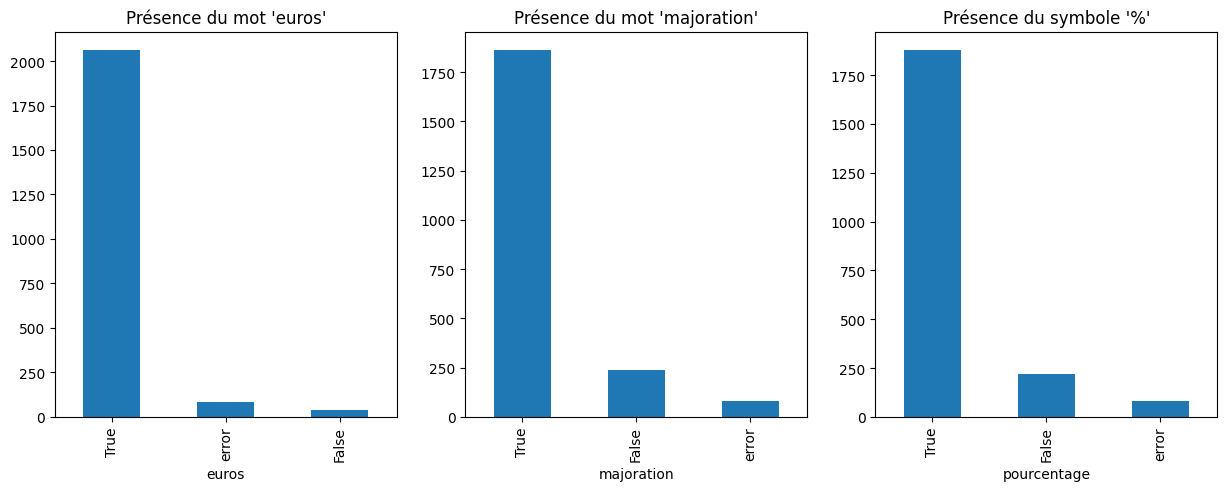

In [23]:
# fonction pour voir si un mot est présent dans un texte
def find_necessary_word(xml_data, mot):

    # gestion des potentielles erreurs
    try :

        # on cherche tous les paragraphes dans le texte intégral
        text = xml_data.findall(".//Decision/Texte_Integral/p")

        # on concatène tous les paragraphes
        text = "   ".join([p.text for p in text])
        
        # returns True if the word is in the text
        if re.search(mot, text):
            return True
        else:
            return False
    
    except:
        return "error"


# on cherche la présence du mot "euros" 
df["euros"] = df["path"].apply(lambda x: find_necessary_word(read_xml(x), "euros"))

# on cherche la présence du mot "majoration"
df["majoration"] = df["path"].apply(lambda x: find_necessary_word(read_xml(x), "majoration"))

# on cherche un pourcentage
df["pourcentage"] = df["path"].apply(lambda x: find_necessary_word(read_xml(x), "%"))

# on affiche des graphiques pour voir la répartition des données

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df["euros"].value_counts().plot(kind="bar", ax=ax[0])
ax[0].set_title("Présence du mot 'euros'")

df["majoration"].value_counts().plot(kind="bar", ax=ax[1])
ax[1].set_title("Présence du mot 'majoration'")
df["pourcentage"].value_counts().plot(kind="bar", ax=ax[2])
ax[2].set_title("Présence du symbole '%'")

plt.show()


Visiblement on est plutôt bons là-dessus.

On considère donc que les décisions que l'on a gardé sont les bonnes.

## 3. Quelques vérifications aléatoires

Pour vérifier que nos règles fonctionnent bien, on va ouvrir des fichiers et vérifier qu'ils sont bien categorisés.

In [9]:
# on prend un fichier catégorisé comme ayant une majoration
index = df[df.majoration != "other"].sample(1).index[0]

# on récupère le chemin du fichier
path = df.loc[index, "path"]

# on récupère la majoration qui a été attribuée
majoration = df.loc[index, "majoration"]

# on l'ouvre avec Visual Studio Code
os.system(f"code {path}")

# on affiche la majoration
print(majoration)

40%


Ces tests aléatoires semblent confirmer le bon fonctionnement de notre méthode.

## 4. Graphique : quels sont les résultats ?

Avec ces premières règles on a un corpus de **2300 décisions**. 

De manière assez prévisible, plus la sanction est importante, moins il y a de cas.

NB : 
- on a laissé les chiffres visibles pour pouvoir faire des graphiques propres
- on ne prend que les décisions pas les ordonnances de renvoi

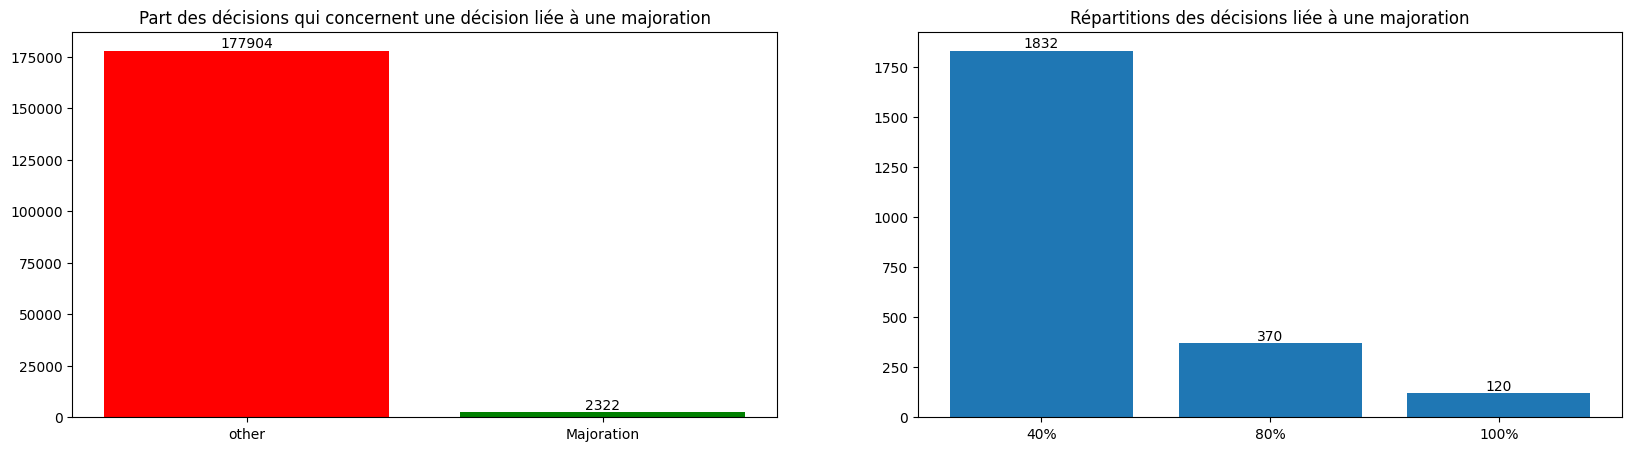

In [11]:
# remove ordonnances de renvoie
df = df[df.ordonnance_de_renvoi == False]

plot, axs = plt.subplots(1, 2, figsize=(20, 5))

# plot 1 : other vs Majoration
nb_1 = df[df.majoration == "other"].shape[0]
nb_2 = df[df.majoration != "other"].shape[0]

axs[0].bar(["other", "Majoration"], [nb_1, nb_2], color=["red", "green"])
axs[0].set_title(
    "Part des décisions qui concernent une décision liée à une majoration"
)

# plot 2 : 40% vs 80% vs 100%
nb_40 = df[df.majoration == "40%"].shape[0]
nb_80 = df[df.majoration == "80%"].shape[0]
nb_100 = df[df.majoration == "100%"].shape[0]

axs[1].bar(["40%", "80%", "100%"], [nb_40, nb_80, nb_100])
axs[1].set_title(
    "Répartitions des décisions liée à une majoration"
)

# set the numbers on top of the bars
for i in range(2):
    for bar in axs[i].patches:
        yval = bar.get_height()
        axs[i].text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval),
            ha="center",
            va="bottom",
        )

plt.show()

# save image
plot.savefig("../output/répartitions_des_majorations.png")